d:\Workspace\ML\NIRS\nirs4all\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Starting pipeline run with 1 pipeline configuration(s) on 1 dataset configuration(s) (1 total runs).
📥 Loaded 25 predictions from results\regression\regression_predictions.json
✅ Loaded dataset 'regression' with 130 training and 59 test samples.
🚀 Starting pipeline config_pipeline_Q1_bed651 on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: {'class': 'sklearn.preprocessing._data.MinMaxScaler', '_runtime_instance': MinMaxScaler()}
🔹 Executing controller TransformerMixinController with operator MinMaxScaler
🔄 TransformerMixin (MinMaxScaler)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 2: {'y_processing': {'class': 'sklearn.preprocessing._data.MinM

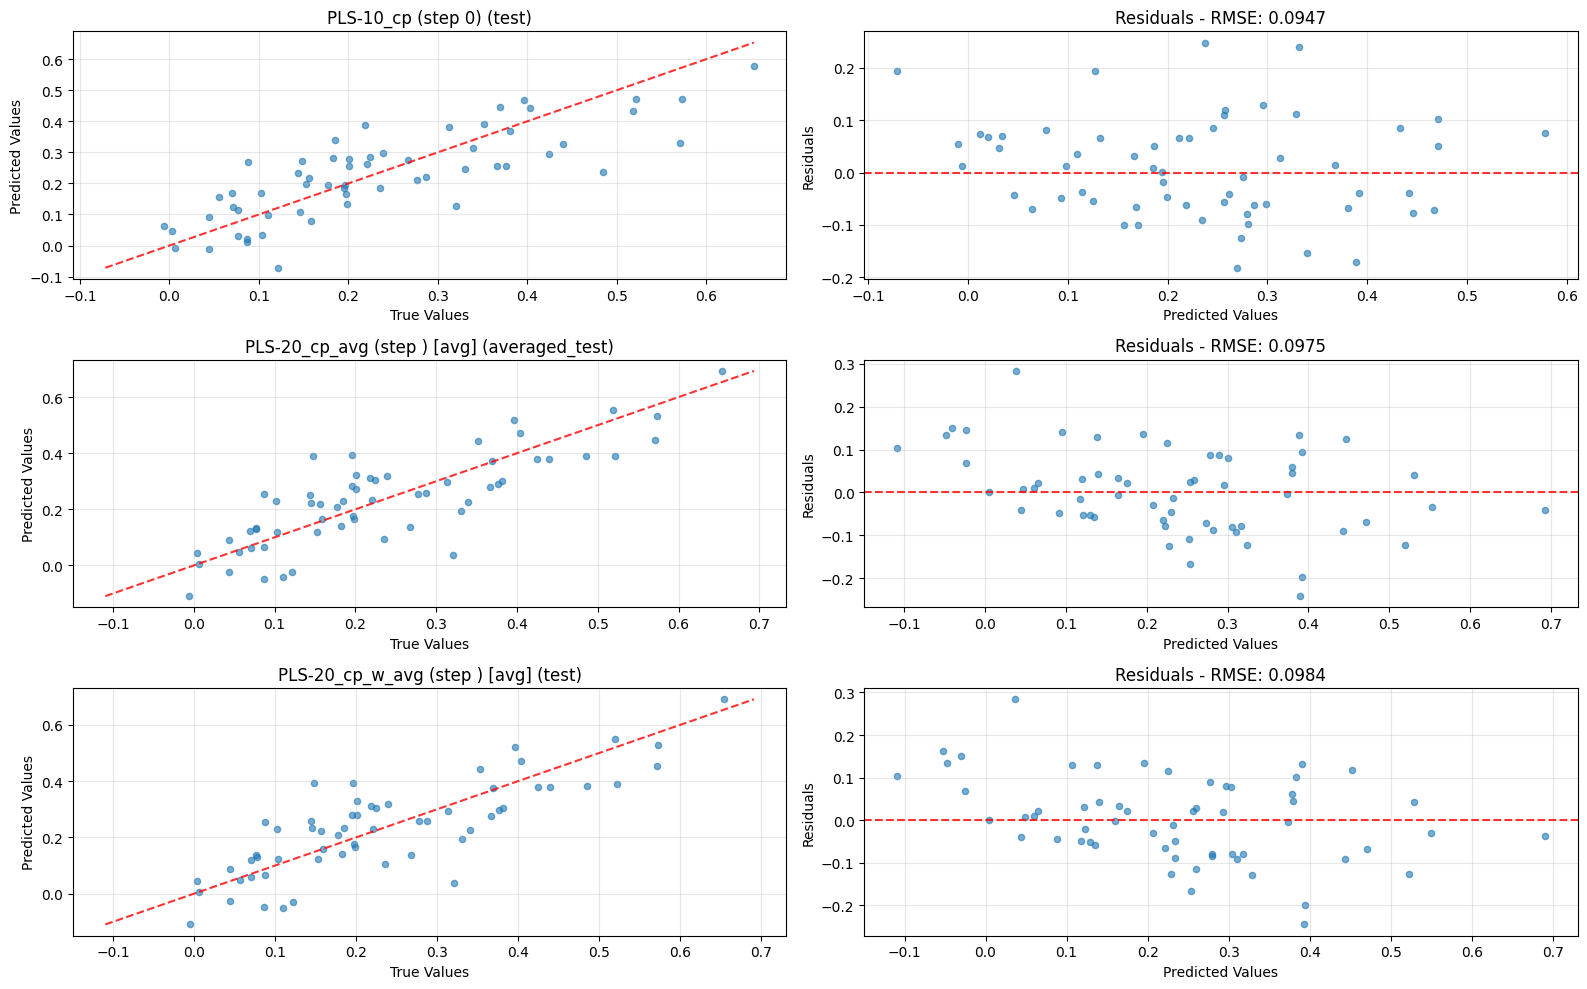

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from nirs4all.dataset import DatasetConfigs
from nirs4all.operators.transformations import Detrend, FirstDerivative, SecondDerivative, Gaussian, StandardNormalVariate, SavitzkyGolay, Haar, MultiplicativeScatterCorrection
from nirs4all.pipeline import PipelineConfigs, PipelineRunner
from sklearn.ensemble import RandomForestRegressor
from nirs4all.operators.models.cirad_tf import nicon
from nirs4all.dataset.prediction_analyzer import PredictionAnalyzer


x_scaler = MinMaxScaler()  # StandardScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer(), LogTransform()
y_scaler = MinMaxScaler()
list_of_preprocessors = [Detrend, FirstDerivative, SecondDerivative, Gaussian, StandardNormalVariate, SavitzkyGolay, Haar, MultiplicativeScatterCorrection]
splitting_strategy = ShuffleSplit(n_splits=3, test_size=.25)
dataset_folder = '../sample_data/regression'

pipeline = [
    # "chart_2d",
    x_scaler,
    # "chart_3d",
    {"y_processing": y_scaler},
    # {"feature_augmentation": { "_or_": list_of_preprocessors, "size":[1,(1,2)], "count":5 }}, # Generate all elements of size 1 and of order 1 or 2 (ie. "Gaussian", ["SavitzkyGolay", "Log"], etc.)
    # {"model": nicon}, # Initial model to compare with

    PLSRegression(n_components=10),
    splitting_strategy,
]

for i in range(10, 30, 10):
    model = {
        "name": f"PLS-{i}_cp",
        "model": PLSRegression(n_components=i)
    }
    pipeline.append(model)

pipeline_config = PipelineConfigs(pipeline, "pipeline_Q1")
dataset_config = DatasetConfigs(dataset_folder)

# Create pipeline with verbose=1 to see debug output
runner = PipelineRunner(save_files=True, verbose=0)
run_predictions, other_predictions = runner.run(pipeline_config, dataset_config)

###############################################################################################################

analyzer = PredictionAnalyzer(run_predictions)

# Get top models to verify the real model names are displayed correctly
top_10 = analyzer.get_top_k(100, 'mse')
print(f"Top 10 models by MSE:")
for i, model in enumerate(top_10):
    real_model = model.get('real_model', 'unknown')
    enhanced_name = model.get('enhanced_model_name', 'unknown')
    pipeline_path = model.get('path', '')

    # Extract config ID from pipeline path
    config_id = "unknown"
    if 'config_' in pipeline_path:
        config_part = pipeline_path.split('config_')[1].split('/')[0] if '/' in pipeline_path else pipeline_path.split('config_')[1]
        config_id = f"config_{config_part}"

    print(f"{i}. Real: {real_model} | Config: {config_id} | RMSE: {model['metrics']['rmse']:.6f} | MSE: {model['metrics']['mse']:.6f} | R²: {model['metrics']['r2']:.6f} | Enhanced: {enhanced_name}")


# Plot comparison with enhanced names (for readability in plots)
fig = analyzer.plot_top_k_comparison(k=3, metric='rmse', partition_type='test')
plt.show()